<a href="https://colab.research.google.com/github/gna-rus/EXP_analysis/blob/main/EXP_TFT_RC_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача:
Предсказать параметр Von, зная исключительно параметры сопротивления и емкости

In [429]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

pd.options.mode.copy_on_write = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [430]:
# Загружаю файлы
# df_RC = pd.read_csv('/content/drive/MyDrive/for_EXP/IGZO RC Database Ref4-5.csv', encoding = 'windows-1251')
df_RC_SiN200N = pd.read_csv('/content/drive/MyDrive/for_EXP/IGZO RC Database Data Ref4 + SiNx 200nm Nominal_new.csv', encoding = 'windows-1251')

# df_TFT = pd.read_csv('/content/drive/MyDrive/for_EXP/IGZO TFT Database Data Ref4-5.csv',  encoding = 'windows-1251')
df_TFT_SiN200N = pd.read_csv('/content/drive/MyDrive/for_EXP/IGZO TFT Database Data Ref4 + SiNx 200nm Nominal.csv',  encoding = 'windows-1251')

In [431]:
df_RC_SiN200N = df_RC_SiN200N.drop(['PEM 24 points', 'Measurement date', 'Bake', 'Layer', 'Platform', 'X_SUSS',	'Y_SUSS' ,'X_PRB' ,'Y_PRB', 'TFT Performance', 'Platform', 'Panel', 'Index', 'LOT'], axis = 1)
df_RC_SiN200Nf

,Panel index,Description,PEM,Measured value,Key,Measurement Structure,Measurement settings,# of VIAs,L_Design,W_Design,S_Design,Capasitance,Sheet resistance,VIA resistance,Resistance,Leakage current
0,EXP69-3,Reference 4 +SiNx 200nm,X35-Y1,"6,85502e-12",Cap,Capacitor SD-GATE,V=0.1V @10kHz,NaN,270.0,81.0,22000.0,"31,2",NaN,NaN,NaN,NaN
1,EXP69-3,Reference 4 +SiNx 200nm,X35-Y1,"2,56411e-12",Cap,Capacitor GATE-SEMIA,V=0.1V @1kHz,NaN,270.0,20.0,5500.0,"46,6",NaN,NaN,NaN,NaN
2,EXP69-3,Reference 4 +SiNx 200nm,X35-Y1,"104,286",4PP,Line GATE,NaN,NaN,5.0,195.0,NaN,NaN,"2,7",NaN,NaN,NaN
3,EXP69-3,Reference 4 +SiNx 200nm,X35-Y1,"14,8407",4PP,Line SD,NaN,NaN,5.0,195.0,NaN,NaN,"0,4",NaN,NaN,NaN
4,EXP69-3,Reference 4 +SiNx 200nm,X35-Y1,"53876,1",4PP,Line SEMIA,NaN,NaN,5.0,195.0,NaN,NaN,"1381,4",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,EXP80-1,Reference 4 +SiNx 200nm,X35-Y55,"55178,8",4PP,Line SEMIA,NaN,NaN,5.0,195.0,NaN,NaN,"1414,8",NaN,NaN,NaN
1931,EXP80-1,Reference 4 +SiNx 200nm,X35-Y55,2796250000,4PP,Line GATE-SEMIA,NaN,NaN,5.0,295.0,NaN,NaN,"47394067,8",NaN,NaN,NaN
1932,EXP80-1,Reference 4 +SiNx 200nm,X35-Y55,"383,315",VIA,VIA SD-GATE,NaN,180.0,5.0,5.0,NaN,NaN,NaN,2.0,NaN,NaN
1933,EXP80-1,Reference 4 +SiNx 200nm,X35-Y55,144548,VIA,VIA SD-SEMIA,NaN,180.0,5.0,5.0,NaN,NaN,NaN,803.0,NaN,NaN


# **Корректрирую таблицу RC**

In [432]:
# Создаю новые колонки и заполняю
df_RC_SiN200N['Capacitor_SD-GATE'] = -1
df_RC_SiN200N['Capacitor_GATE-SEMIA'] = -1
df_RC_SiN200N['IGZO_Serpentine'] = -1


df_RC_SiN200N['ME1_E_Line_GATE'] = -1
df_RC_SiN200N['IGZO-E_Line_SEMIA'] = -1
df_RC_SiN200N['IGZO-E_Line_GATE-SEMIA'] = -1
df_RC_SiN200N['VI1-E_VIA_SD-GATE'] = -1
df_RC_SiN200N['VI1-E_VIA_SD-SEMIA'] = -1
df_RC_SiN200N['Line_SD_Line_SD'] = -1
# 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'Line_SD_Line_SD'

In [433]:
# Присваиваю значение
def set_value_from_MS(row):
  if row['Measurement Structure'] == 'Capacitor SD-GATE':
    row['Capacitor_SD-GATE'] = row['Capasitance']

  elif row['Measurement Structure'] == 'Capacitor GATE-SEMIA':
    row['Capacitor_GATE-SEMIA'] = row['Capasitance']

  elif row['Measurement Structure'] == 'Line GATE':
    row['ME1_E_Line_GATE'] = row['Sheet resistance']

  elif row['Measurement Structure'] == 'Line SEMIA':
    row['IGZO-E_Line_SEMIA'] = row['Sheet resistance']

  elif row['Measurement Structure'] == 'Line GATE-SEMIA':
    row['IGZO-E_Line_GATE-SEMIA'] = row['Sheet resistance']

  elif row['Measurement Structure'] == 'Line SD':
    row['SD1-E_Line_SD'] = row['Sheet resistance']

  elif row['Measurement Structure'] == 'VIA SD-GATE':
    row['VI1-E_VIA_SD-GATE'] = row['VIA resistance']

  elif row['Measurement Structure'] == 'VIA SD-SEMIA':
    row['VI1-E_VIA_SD-SEMIA'] = row['VIA resistance']



  elif row['Measurement Structure'] == 'IGZO Serpentine':
    row['IGZO_Serpentine'] = row['Resistance']

  return row

df_RC_SiN200N = df_RC_SiN200N.apply(set_value_from_MS, axis=1)

In [434]:
df_RC_SiN200N

,# of VIAs,Capacitor_GATE-SEMIA,Capacitor_SD-GATE,Capasitance,Description,IGZO-E_Line_GATE-SEMIA,IGZO-E_Line_SEMIA,IGZO_Serpentine,Key,L_Design,Leakage current,Line_SD_Line_SD,ME1_E_Line_GATE,Measured value,Measurement Structure,Measurement settings,PEM,Panel index,Resistance,SD1-E_Line_SD,S_Design,Sheet resistance,VI1-E_VIA_SD-GATE,VI1-E_VIA_SD-SEMIA,VIA resistance,W_Design
0,NaN,-1,"31,2","31,2",Reference 4 +SiNx 200nm,-1,-1,-1.0,Cap,270.0,NaN,-1,-1,"6,85502e-12",Capacitor SD-GATE,V=0.1V @10kHz,X35-Y1,EXP69-3,NaN,NaN,22000.0,NaN,-1.0,-1.0,NaN,81.0
1,NaN,"46,6",-1,"46,6",Reference 4 +SiNx 200nm,-1,-1,-1.0,Cap,270.0,NaN,-1,-1,"2,56411e-12",Capacitor GATE-SEMIA,V=0.1V @1kHz,X35-Y1,EXP69-3,NaN,NaN,5500.0,NaN,-1.0,-1.0,NaN,20.0
2,NaN,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,-1,-1.0,4PP,5.0,NaN,-1,"2,7","104,286",Line GATE,NaN,X35-Y1,EXP69-3,NaN,NaN,NaN,"2,7",-1.0,-1.0,NaN,195.0
3,NaN,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,-1,-1.0,4PP,5.0,NaN,-1,-1,"14,8407",Line SD,NaN,X35-Y1,EXP69-3,NaN,"0,4",NaN,"0,4",-1.0,-1.0,NaN,195.0
4,NaN,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,"1381,4",-1.0,4PP,5.0,NaN,-1,-1,"53876,1",Line SEMIA,NaN,X35-Y1,EXP69-3,NaN,NaN,NaN,"1381,4",-1.0,-1.0,NaN,195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,NaN,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,"1414,8",-1.0,4PP,5.0,NaN,-1,-1,"55178,8",Line SEMIA,NaN,X35-Y55,EXP80-1,NaN,NaN,NaN,"1414,8",-1.0,-1.0,NaN,195.0
1931,NaN,-1,-1,NaN,Reference 4 +SiNx 200nm,"47394067,8",-1,-1.0,4PP,5.0,NaN,-1,-1,2796250000,Line GATE-SEMIA,NaN,X35-Y55,EXP80-1,NaN,NaN,NaN,"47394067,8",-1.0,-1.0,NaN,295.0
1932,180.0,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,-1,-1.0,VIA,5.0,NaN,-1,-1,"383,315",VIA SD-GATE,NaN,X35-Y55,EXP80-1,NaN,NaN,NaN,NaN,2.0,-1.0,2.0,5.0
1933,180.0,-1,-1,NaN,Reference 4 +SiNx 200nm,-1,-1,-1.0,VIA,5.0,NaN,-1,-1,144548,VIA SD-SEMIA,NaN,X35-Y55,EXP80-1,NaN,NaN,NaN,NaN,-1.0,803.0,803.0,5.0


In [435]:
df_RC_SiN200N = df_RC_SiN200N.rename({'Panel index': 'Lot-panel'}, axis=1)

In [436]:
df_merge_RC_TFT = df_RC_SiN200N.merge(df_TFT_SiN200N,how='left',on=['Lot-panel','PEM'])


In [437]:
df_merge_RC_TFT['Measurement settings'].value_counts()

Measurement settings
@10KHz           191
@1KHz            191
V=0.1V @10kHz     24
V=0.1V @1kHz      24
Name: count, dtype: int64

In [438]:
df_merge_RC_TFT = df_merge_RC_TFT.drop(['п»їDate and time','Source Table 2','key for uniformity','SQL','SQL 2', 'SQL 3', 'SQL 4', 'SQL 5', 'SQL 6', 'SQL 7', 'SQL 8', 'SQL 9', 'Lot', 'L'], axis=1)

In [439]:
for i in df_merge_RC_TFT:
  df_merge_RC_TFT[i] = df_merge_RC_TFT[i].fillna(-1)

# **Обучающая и тестовая выборка**

In [440]:
# Трансформирую тип колонок
correct_list = ['Capasitance','Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD', 'Sheet resistance', 'Von']
# 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'Line_SD_Line_SD'
# 'Capacitor GATE-SEMIA','Capacitor_SD-GATE','Capasitance',
    # 'IGZO-E_Line_GATE-SEMIA','IGZO-E_Line_SEMIA','IGZO_Serpentine',
    # 'ME1_E_Line_GATE','VI1-E_VIA_SD-GATE','VI1-E_VIA_SD-SEMIA',
    # 'VIA resistance','Hyst','Id(Von+3V)','Resistance',
    # 'Line Gate-SEMIA', 'IGZO Serpantine','SS', 'Ioff', 'Id(Von+3V)',
    # 'Capasitance', 'Von']
for i in df_merge_RC_TFT:
  if i in correct_list and df_merge_RC_TFT[i].dtype  == 'O':
    df_merge_RC_TFT[i] = df_merge_RC_TFT[i].str.replace(',', '.').astype(float).fillna(-1)


In [441]:
# Создаю таблицу у которой Von != -10 и сбрасываю индексы
df_merge_RC_TFT = df_merge_RC_TFT.reset_index()
new_df_merge_RC_TFT = df_merge_RC_TFT[df_merge_RC_TFT['Von']!=-10]


In [442]:
df_merge_RC_TFT.shape[0] - new_df_merge_RC_TFT.shape[0]

72

In [443]:
# Создаю выборки для настройки модели (использую только данные с Description == Reference 4 +SiNx 200nm	из первичных данных)
small_df, train = train_test_split(new_df_merge_RC_TFT,train_size=0.03,random_state=42)
train, val = train_test_split(train,train_size=0.8,random_state=42)

# train - данные для основного обучения
# val - проверочные данные (валидационные данные)
# small_df - данные для финального теста (нужна для того чтобы избежать переобучения)

In [444]:
df_merge_RC_TFT[df_merge_RC_TFT['Von'] == -10]

,index,# of VIAs,Capacitor_GATE-SEMIA,Capacitor_SD-GATE,Capasitance,Description_x,IGZO-E_Line_GATE-SEMIA,IGZO-E_Line_SEMIA,IGZO_Serpentine,Key,L_Design,Leakage current,Line_SD_Line_SD,ME1_E_Line_GATE,Measured value,Measurement Structure,Measurement settings,PEM,Lot-panel,Resistance,SD1-E_Line_SD,S_Design,Sheet resistance,VI1-E_VIA_SD-GATE,VI1-E_VIA_SD-SEMIA,VIA resistance,W_Design,XPEM,YPEM,X,Y,Р РµС†РµРїС‚,Panel,Description_y,TFT,Regime,Vfix,Anneal,Von,Hyst,Id(Von+1V),Id(Von+2V),Id(Von+3V),Id(Von+4V),SS,Ioff,Cni,Rtot2,Rtot3,Rtot4,Gate Ox leakage,Cox,IGZO Serpentine,Line gate,Line gate SEMIA,Line SD,Line SEMIA,VIA SD-GATE,VIA SD-SEMIA,vt,von or vt,Cni/Cox,Line Gate-SEMIA,IGZO Serpantine,VIA Gate-SD,VIA SEMIA,Id/meanId,Cox/meanCox,Cox/Cni,PEM 24 points,uniformity for Von,Id(Von+2V) filter,uniformity for Id(Von+2V),Id(Von+3V) filter,uniformity for Id(Von+3V),uniformity for Hyst
18,18,-1.0,-1.0,1.4,1.4,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,Cap,270.0,-1.0,-1,-1.0,"3,14498e-13",Capacitor SD-GATE,V=0.1V @10kHz,X22-Y2,EXP69-3,-1.0,-1.0,22000.0,-1.0,-1.0,-1.0,-1.0,81.0,4,1,217232,326776,IGZO_TFT_24P,3,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.0,0,"-2,8819e-14","-4,02271e-14","-2,89262e-14","-2,6214e-14","0,4897028393",-1,"1,43","-2,48589e+12","-3,45707e+12","-3,81476e+12",-1.0,"34,46",-1.0,-1.0,-1.0,-1.0,"102428205,13",-1.0,-1.0,-1.0,-1,"0,0414849189","60504237,29",8415160.0,"2,10","53148,50","-4,772158e-8","1,1462736126","24,105145343",-1.0,-1,-1,-1,-1,-1,-1
19,19,-1.0,42.7,-1.0,42.7,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,Cap,270.0,-1.0,-1,-1.0,"2,3468e-12",Capacitor GATE-SEMIA,V=0.1V @1kHz,X22-Y2,EXP69-3,-1.0,-1.0,5500.0,-1.0,-1.0,-1.0,-1.0,20.0,4,1,217232,326776,IGZO_TFT_24P,3,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.0,0,"-2,8819e-14","-4,02271e-14","-2,89262e-14","-2,6214e-14","0,4897028393",-1,"1,43","-2,48589e+12","-3,45707e+12","-3,81476e+12",-1.0,"34,46",-1.0,-1.0,-1.0,-1.0,"102428205,13",-1.0,-1.0,-1.0,-1,"0,0414849189","60504237,29",8415160.0,"2,10","53148,50","-4,772158e-8","1,1462736126","24,105145343",-1.0,-1,-1,-1,-1,-1,-1
20,20,-1.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,4PP,5.0,-1.0,-1,5.8,"225,41",Line GATE,-1,X22-Y2,EXP69-3,-1.0,-1.0,-1.0,5.8,-1.0,-1.0,-1.0,195.0,4,1,217232,326776,IGZO_TFT_24P,3,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.0,0,"-2,8819e-14","-4,02271e-14","-2,89262e-14","-2,6214e-14","0,4897028393",-1,"1,43","-2,48589e+12","-3,45707e+12","-3,81476e+12",-1.0,"34,46",-1.0,-1.0,-1.0,-1.0,"102428205,13",-1.0,-1.0,-1.0,-1,"0,0414849189","60504237,29",8415160.0,"2,10","53148,50","-4,772158e-8","1,1462736126","24,105145343",-1.0,-1,-1,-1,-1,-1,-1
21,21,-1.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,4PP,5.0,-1.0,-1,-1.0,"13,0821",Line SD,-1,X22-Y2,EXP69-3,-1.0,0.3,-1.0,0.3,-1.0,-1.0,-1.0,195.0,4,1,217232,326776,IGZO_TFT_24P,3,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.0,0,"-2,8819e-14","-4,02271e-14","-2,89262e-14","-2,6214e-14","0,4897028393",-1,"1,43","-2,48589e+12","-3,45707e+12","-3,81476e+12",-1.0,"34,46",-1.0,-1.0,-1.0,-1.0,"102428205,13",-1.0,-1.0,-1.0,-1,"0,0414849189","60504237,29",8415160.0,"2,10","53148,50","-4,772158e-8","1,1462736126","24,105145343",-1.0,-1,-1,-1,-1,-1,-1
22,22,-1.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,102428205.1,-1.0,4PP,5.0,-1.0,-1,-1.0,3994700000,Line SEMIA,-1,X22-Y2,EXP69-3,-1.0,-1.0,-1.0,102428205.1,-1.0,-1.0,-1.0,195.0,4,1,217232,326776,IGZO_TFT_24P,3,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.0,0,"-2,8819e-14","-4,02271e-14","-2,89262e-14","-2,6214e-14","0,4897028393",-1,"1,43","-2,48589e+12","-3,45707e+12","-3,81476e+12",-1.0,"34,46",-1.0,-1.0,-1.0,-1.0,"102428205,13",-1.0,-1.0,-1.0,-1,"0,0414849189","60504237,29",8415160.0,"2,10","53148,50","-4,772158e-8","1,1462736126","24,105145343",-1.0,-1,-1,-1,-1,-1,-1
23,23,-1.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,60504237.3,-1.0,-1.0,4PP,5.0,-1.0,-1,-1.0,3569750000,Line GATE-SEMIA,-1,X22-Y2,EXP69-3,-1.

In [445]:
df_merge_RC_TFT[(df_merge_RC_TFT['Lot-panel']=='EXP74-1') & (df_merge_RC_TFT['Measurement Structure']=='VIA SD-SEMIA')].head(10)

,index,# of VIAs,Capacitor_GATE-SEMIA,Capacitor_SD-GATE,Capasitance,Description_x,IGZO-E_Line_GATE-SEMIA,IGZO-E_Line_SEMIA,IGZO_Serpentine,Key,L_Design,Leakage current,Line_SD_Line_SD,ME1_E_Line_GATE,Measured value,Measurement Structure,Measurement settings,PEM,Lot-panel,Resistance,SD1-E_Line_SD,S_Design,Sheet resistance,VI1-E_VIA_SD-GATE,VI1-E_VIA_SD-SEMIA,VIA resistance,W_Design,XPEM,YPEM,X,Y,Р РµС†РµРїС‚,Panel,Description_y,TFT,Regime,Vfix,Anneal,Von,Hyst,Id(Von+1V),Id(Von+2V),Id(Von+3V),Id(Von+4V),SS,Ioff,Cni,Rtot2,Rtot3,Rtot4,Gate Ox leakage,Cox,IGZO Serpentine,Line gate,Line gate SEMIA,Line SD,Line SEMIA,VIA SD-GATE,VIA SD-SEMIA,vt,von or vt,Cni/Cox,Line Gate-SEMIA,IGZO Serpantine,VIA Gate-SD,VIA SEMIA,Id/meanId,Cox/meanCox,Cox/Cni,PEM 24 points,uniformity for Von,Id(Von+2V) filter,uniformity for Id(Von+2V),Id(Von+3V) filter,uniformity for Id(Von+3V),uniformity for Hyst
439,439,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,146741,VIA SD-SEMIA,-1,X35-Y1,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,815.0,815.0,5.0,6,1,347224,332816,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,0.600246,"0,399916","6,196965e-8","2,78945e-7","6,093065e-7","1,002864e-6","0,3206312274","1,66614e-13",-1,"358493,60985","164121,01299","99714,417907",-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,"0,600246",-1,-1,-1.0,-1,-1,"1,0082770426",-1,-1,1.0,"0,3992282748","2,78945e-7","68,8","6,093065e-7","68,3","52,3"
448,448,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,152152,VIA SD-SEMIA,-1,X8-Y2,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,845.0,845.0,5.0,2,1,77242,326776,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,0.600171,"0,399933","1,3618255e-7","5,458775e-7","1,109035e-6","1,75628e-6","0,3013670942","1,465887e-13",-1,"183191,28376","90168,479805","56938,529164",-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,"0,6001715",-1,-1,-1.0,-1,-1,"1,835225014",-1,-1,1.0,"0,3992282748","5,458775e-7","68,8","1,109035e-6","68,3","52,3"
457,457,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,9395500,VIA SD-SEMIA,-1,X22-Y2,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,52197.0,52197.0,5.0,4,1,217232,326776,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,-10.000000,0,"-1,94135e-14","-3,91009e-14","-2,7329e-14","-3,4934e-14","0,7218516345",-1,-1,"-2,55749e+12","-3,65912e+12","-2,86254e+12",-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1.0,-1,-1,"-4,522388e-8",-1,-1,-1.0,-1,-1,-1,-1,-1,-1
466,466,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,143576,VIA SD-SEMIA,-1,X2-Y12,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,798.0,798.0,5.0,1,2,17252,266766,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,0.400244,"0,399792","1,066627e-7","4,479375e-7","9,265695e-7","1,475095e-6","0,306643502","1,574313e-13",-1,"223245,43045","107924,98566","67792,243889",-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,"0,400244",-1,-1,-1.0,-1,-1,"1,5332821088",-1,-1,1.0,"0,3992282748","4,479375e-7","68,8","9,265695e-7","68,3","52,3"
475,475,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,141836,VIA SD-SEMIA,-1,X16-Y12,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,788.0,788.0,5.0,3,2,157232,266787,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,0.600189,"0,399978","8,1422e-8","3,73396e-7","8,112615e-7","1,32643e-6","0,3035978321","1,460921e-13",-1,"267812,18867","123264,81659","75390,333451",-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,"0,600189",-1,-1,-1.0,-1,-1,"1,3424710651",-1,-1,1.0,"0,3992282748","3,73396e-7","68,8","8,112615e-7","68,3","52,3"
484,484,180.0,-1.0,-1.0,-1.0,Reference 4 +SiNx 200nm,-1.0,-1.0,-1.0,VIA,5.0,-1.0,-1,-1.0,137336,VIA SD-SEMIA,-1,X30-Y12,EXP74-1,-1.0,-1.0,-1.0,-1.0,-1.0,763.0,763.0,5.0,5,2,297222,266766,IGZO_TFT_24P,1,Reference 4 +SiNx 200nm,Nominal,Linear,Vd=1V,220C 30 min,0.700349,"0,600261","5,790085e-8","2,30547e-7","4,970

In [488]:
all = ['Index', 'Platform', 'Lot-panel', 'Description_x', 'Bake', 'Layer',
       'X_SUSS', 'Y_SUSS', 'PEM', 'X_PRB', 'Y_PRB', 'Measured value', 'Key',
       'Measurement Structure', 'Measurement settings', '# of VIAs',
       'L_Design', 'W_Design', 'S_Design', 'Capasitance', 'Sheet resistance',
       'VIA resistance', 'Resistance', 'Leakage current', 'TFT Performance',
       'Measurement date', 'PEM 24 points_x', 'XPEM', 'YPEM', 'X', 'Y',
       'Р РµС†РµРїС‚', 'Lot', 'Panel_y', 'Description_y', 'TFT', 'L', 'Regime',
       'Vfix', 'Anneal', 'Von', 'Hyst', 'Id(Von+1V)', 'Id(Von+2V)',
       'Id(Von+3V)', 'Id(Von+4V)', 'SS', 'Ioff', 'Cni', 'Rtot2', 'Rtot3',
       'Rtot4', 'Gate Ox leakage', 'Cox', 'IGZO Serpentine', 'Line gate',
       'Line gate SEMIA', 'Line SD', 'Line SEMIA', 'VIA SD-GATE',
       'VIA SD-SEMIA', 'vt', 'von or vt', 'Cni/Cox', 'Line Gate-SEMIA',
       'IGZO Serpantine', 'VIA Gate-SD', 'VIA SEMIA', 'Id/meanId',
       'Cox/meanCox', 'Cox/Cni', 'PEM 24 points_y', 'uniformity for Von',
       'Id(Von+2V) filter', 'uniformity for Id(Von+2V)', 'Id(Von+3V) filter',
       'uniformity for Id(Von+3V)', 'uniformity for Hyst']

X = [ 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA'
     ]

# 'Capacitor_SD-GATE', '                    ', '                ', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', '
# Список категориальных фичей (не числовые)
cat_features = []

# Целевой признак
Y = ['Von']

In [447]:
# Таблица для проверки верности перевода данных из колонки в колонку
train_for_corr = train[['Lot-panel','Measurement Structure', 'PEM','Sheet resistance','Capasitance','Resistance','Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine',
     'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA',
     'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD', 'Von']]
train_for_corr.head(20)

,Lot-panel,Measurement Structure,PEM,Sheet resistance,Capasitance,Resistance,Capacitor_SD-GATE,Capacitor_GATE-SEMIA,IGZO_Serpentine,ME1_E_Line_GATE,IGZO-E_Line_SEMIA,IGZO-E_Line_GATE-SEMIA,VI1-E_VIA_SD-GATE,VI1-E_VIA_SD-SEMIA,SD1-E_Line_SD,Von
949,EXP74-3,Line SEMIA,X22-Y20,1271.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1271.4,-1.0,-1.0,-1.0,-1.0,0.099809
1360,EXP75-1,Capacitor GATE-SEMIA,X9-Y19,-1.0,29.6,-1.0,-1.0,29.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.600156
1383,EXP75-1,VIA SD-GATE,X22-Y20,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.700333
1734,EXP80-1,VIA SD-GATE,X35-Y1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.300825
1583,EXP75-2,IGZO Serpentine,X9-Y19,-1.0,-1.0,1324380.0,-1.0,-1.0,1324380.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.500169
1150,EXP74-4,VIA SD-SEMIA,X9-Y19,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,851.0,-1.0,0.300301
1569,EXP75-2,Line SD,X42-Y12,0.3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.3,0.300322
265,EXP72-4,Line SEMIA,X30-Y12,1240.2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1240.2,-1.0,-1.0,-1.0,-1.0,0.700242
613,EXP74-1,Capacitor GATE-SEMIA,X42-Y46,-1.0,36.6,-1.0,-1.0,36.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.600239
1347,EXP75-1,VIA SD-GATE,X30-Y12,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.600196


# **HeatMap через phik**

In [448]:
! pip install phik
import phik
# Phik полезен при нелинейных взаимосвязях
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['Sheet resistance', 'Capasitance', 'Resistance', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD', 'Von']


<Axes: >

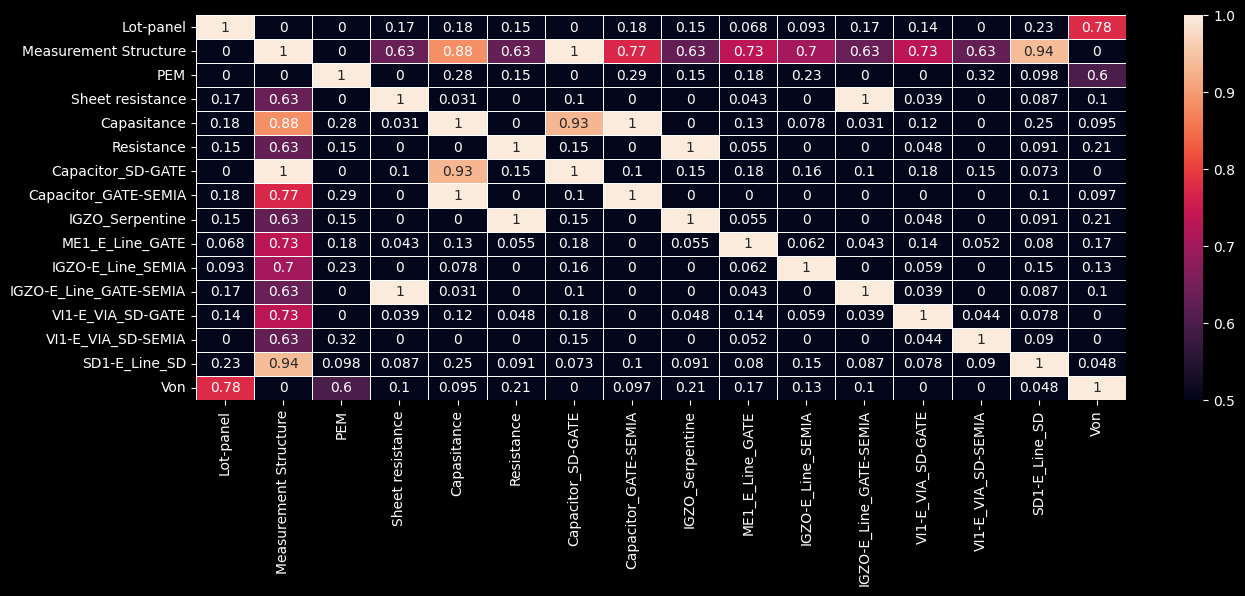

In [449]:
train_corr = train_for_corr.phik_matrix()
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train_corr, annot=True, linewidths=0.5, vmin=0.5)

# **Запуск Кэтбуста**

In [450]:
! pip install catboost

In [451]:
from catboost import CatBoostRegressor
# CatBoostRegressor - если надо предсказать какое-то значение
# CatBoostRanker - используется для ранжирования

In [489]:
# Создаю модель CatBoost (провожу настройку)
model = CatBoostRegressor(cat_features = cat_features,
                          use_best_model=True,
                          iterations=1500,
                          depth = 7, learning_rate = 0.1,
                          early_stopping_rounds = 200,
                          eval_metric = 'Quantile',
                          verbose=100)
# learning_rate =  - коэфициент влияющий на качество обучения каждой итерации (надо настроить так чтобы лучшим обучением было в районе 900, но не больше 999 (из 1000))
# early_stopping_rounds - количество не лучших раундов по достижению которого подряд обучение завершится
# eval_metric='MAPE'/ RMSE / Quantile - задаю метрику для создания модели (читай документацию, метрик много)
# verbose = 100 - выводить каждую 100 итерацию качества
# random_seed = 42, depth = 6, learning_rate = 0.5,

In [490]:
# Передаю в модель обучающие данные
model.fit(train[X],train[Y], eval_set=(val[X],val[Y]))
# model.fit(train[X_test],train[Y], verbose=False)

0:	learn: 0.1982214	test: 0.2078911	best: 0.2078911 (0)	total: 1.76ms	remaining: 2.64s
100:	learn: 0.1907951	test: 0.2092893	best: 0.2077161 (7)	total: 149ms	remaining: 2.07s
200:	learn: 0.1863827	test: 0.2104849	best: 0.2077161 (7)	total: 297ms	remaining: 1.92s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2077161206
bestIteration = 7

Shrink model to first 8 iterations.


# **Предсказание по созданной моделе**

In [454]:
len(small_df)

55

Подсчет ошибки вычислений

In [455]:
error_rate = []
error_rate_per = []

for i in range(len(res_list)):
  error_rate.append(abs(res_list[i] - real_value['Von'].iloc[i]))

for i in range(len(res_list)):
  error_rate_per.append((abs(res_list[i] - real_value['Von'].iloc[i]) /  abs(real_value['Von'].iloc[i])))

err_res1 = sum(error_rate) / len(error_rate)
err_res2 = sum(error_rate_per) / len(error_rate_per)

print(err_res1, err_res2)


0.034999796912394424 0.2968551261012551


In [491]:
# Делаю предсказание по созданной моделе. В Модель загружается df без целевого параметра, а выводится список искомого параметра по каждой строчке
num = 1
offset = 50
res = model.predict(small_df[X])
res_list = list(res)[(num):(num+offset)] # предсказание
real_value = small_df.iloc[(num):(num+offset)] # реальные значения



mean_error = mean_absolute_error(real_value['Von'], res_list)
mean_error_per = mean_absolute_percentage_error(real_value['Von'], res_list)
print("Абсолютное значение ошибки", mean_error)
print("Абсолютное значение ошибки в процентах", mean_error_per)
print(mean_error, " | ",mean_error_per)

# 0.05696906886269756 0.5836373235164181 - 'Lot-panel', 'PEM', 'Measurement Structure', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.4364116604121287 9.005527646150165- 'Lot-panel', "    ", 'Measurement Structure', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.5911478847545645 1.7458804553805598 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.5794412601178581 1.814512994296297 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', '              '
# 0.6383460577107627 8.217603094287822 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', '                   ', '              ' (!)
# 0.6242621485086434 8.12937974521411 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', '                  ', '                   ', '              '
# 0.6544179541086756 8.602812147674188 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', '                     ', '                  ', '                   ', '              '
# 0.6879257818328759 8.94408958400961 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', '                 ', '                     ', '                  ', '                   ', '              '
# 0.7051330879363792 9.156425834456682 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', '               ', '                 ', '                     ', '                  ', '                   ', '              '
# 0.7073105774903965 9.295611190377032 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', '                ', '               ', '                 ', '                     ', '                  ', '                   ', '              '
# 0.7073105774903965 9.295611190377032 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', '                    ', '                ', '               ', '                 ', '                     ', '                  ', '                   ', '              ' (!)
#      error               error       -  '        ', "    ", '                     ', '                 ', 'Capacitor_GATE-SEMIA', '                ', '               ', '                 ', '                     ', '                  ', '                   ', '              '

# 0.666025304907604 2.2448425179018923 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', '                    ', '                ', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', '              ' (!)


Абсолютное значение ошибки 0.41085593385527547
Абсолютное значение ошибки в процентах 3.5384923084563007
0.41085593385527547  |  3.5384923084563007


In [457]:
# Von != -10
# 0.04527658114296175 2.1800403977204383 - 'Lot-panel', 'PEM', 'Measurement Structure', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.1737131811592003 4.541782107316979   - 'Lot-panel', "    ", 'Measurement Structure', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.41292811806789587 3.370625075140152  -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', 'SD1-E_Line_SD'
# 0.4098182380190638 3.3733262467907874 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', '              '
# 0.41125948414422353 4.051558293190065 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', '                   ', '              '
# 0.4088423898822819 3.9266636436792566-  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', '                  ', '                   ', '              '
# 0.4098991032672707 3.711865688833049-  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', '                     ', '                  ', '                   ', '              '
# 0.4068765650124568 3.209684658817259 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', '                 ', '                     ', '                  ', '                   ', '              ' (!) Best выборка под номером 0 !!!!

# 0.04672561629058044 1.8364263065522204 -  '        ', "    ", '                     ', 'Capacitor_SD-GATE', '                    ', '                ', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', '              ' (!)
#  0.4211823544536218 2.892256983229261 -  '        ', "PEM", '                     ', '                 ', '                    ', '                ', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', '
#  0.4098890499076964 3.562909146439957-  '        ', "   ", '                     ', '                 ', 'Capacitor_GATE-SEMIA', '                ', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' '              '

#  0.4098890499076964 3.562909146439957 -  '        ', "   ", '                     ', '                 ', '                    ', 'IGZO_Serpentine', '               ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' '              ' NO!!
#  0.4064379124265457 3.44339965386763377 -  '        ', "   ", '                     ', '                 ', '                    ', '              ', 'ME1_E_Line_GATE', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' '              ' NO!!
#  0.4064379124265457 3.44339965386763377 -  '        ', "PEM", '                     ', '                 ', '                    ', '              ', 'ME1_E_Line_GATE', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' '              ' NO!!
#  0.43559929636380784 2.909709420614884 -  '        ', "PEM", '                     ', '                 ', '                    ', '              ', '                ', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' 'SD1-E_Line_SD' NO!!
#  0.43559929636380784 2.909709420614884 -  '        ', "PEM", '                     ', '                 ', '                    ', '              ', 'ME1_E_Line_GATE', '                 ', '                     ', '                  ', 'VI1-E_VIA_SD-SEMIA', ' 'SD1-E_Line_SD' NO!!
#  0.44952700985312705 2.7570872239411335 -  '        ', "PEM", '                     ', '                 ', '                    ', '              ', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', ' 'SD1-E_Line_SD' NO!!
#  0.42172293594841676 2.1174054565503675 -  '        ', "PEM", '                     ', 'Capacitor_SD-GATE', 'Capacitor_GATE-SEMIA', 'IGZO_Serpentine', 'ME1_E_Line_GATE', 'IGZO-E_Line_SEMIA', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', ' 'SD1-E_Line_SD' NO!!



#  0.028354406232812584 0.24714225447332147 -  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', '               ', '                 ', '                      ', '                 ', 'VI1-E_VIA_SD-SEMIA', ' '             ' (!)
#  0.04538753299588111 1.2688463931452183 -  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', '               ', '                 ', '                      ', '                 ', '                  ', 'SD1-E_Line_SD'
#  0.05117153473443796 0.885350216269016-  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', '               ', '                 ', '                      ', 'VI1-E_VIA_SD-GATE', '                  ', '              ' (!)
#  0.047301586904746146 0.317303608327099-  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', '               ', '                 ', 'IGZO-E_Line_GATE-SEMIA', '                 ', '                  ', '              ' (!)
#  0.04212295370741361 0.43959489107983246-  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', '               ', 'IGZO-E_Line_SEMIA', '                       ', '                 ', '                  ', '              '
#  0.032206216823379125 0.13976026212823045-  'Lot-panel', "PEM", '                     ', '                ', '                    ', '               ', 'ME1_E_Line_GATE', '                 ', '                       ', '                 ', '                  ', '              '(!)
#  0.02800586951596083 0.42401815708358603-  'Lot-panel', "PEM", '                     ', '                ', '                    ', 'IGZO_Serpentine', '                ', '                 ', '                       ', '                 ', '                  ', '              '
#  0.028030314865748505 0.2969602660043138-  'Lot-panel', "PEM", '                     ', '                ', 'Capacitor_GATE-SEMIA', '               ', '                ', '                 ', '                       ', '                 ', '                  ', '              '(!)
#  0.02603798259551958 0.8724753700065898-  'Lot-panel', "PEM", '                     ', 'Capacitor_SD-GATE', '                    ', '               ', '                ', '                 ', '                       ', '                 ', '                  ', '              '

#  0.03499979691239442 0.2968551261012551-  'Lot-panel', "PEM", '                     ', '                ', 'Capacitor_GATE-SEMIA', '               ', 'ME1_E_Line_GATE', '                 ', 'IGZO-E_Line_GATE-SEMIA', 'VI1-E_VIA_SD-GATE', 'VI1-E_VIA_SD-SEMIA', '              '(!!!)

#  'VI1-E_VIA_SD-SEMIA', 'VI1-E_VIA_SD-GATE', 'IGZO-E_Line_GATE-SEMIA',  'ME1_E_Line_GATE', 'Capacitor_GATE-SEMIA'

In [458]:
print(res_list[num:num+10], " ", real_value[num:num+10]['Von'], sep='\n')

[0.4471359314304527, 0.6160089804825336, -1.5022203818831785, 0.05780530491924013, -0.25042161314397804, -0.15564622394280542, -0.7480182855050487, -0.0798550592039162, 0.24373978111514666, 0.3086327689935937]
 
1662    0.500233
589     0.600182
1886   -1.500700
722     0.099799
1002   -0.300731
198    -0.100719
1878   -0.700627
1020   -0.100754
735     0.300233
1571    0.300322
Name: Von, dtype: float64


# **Определение силы зависимости параметров**

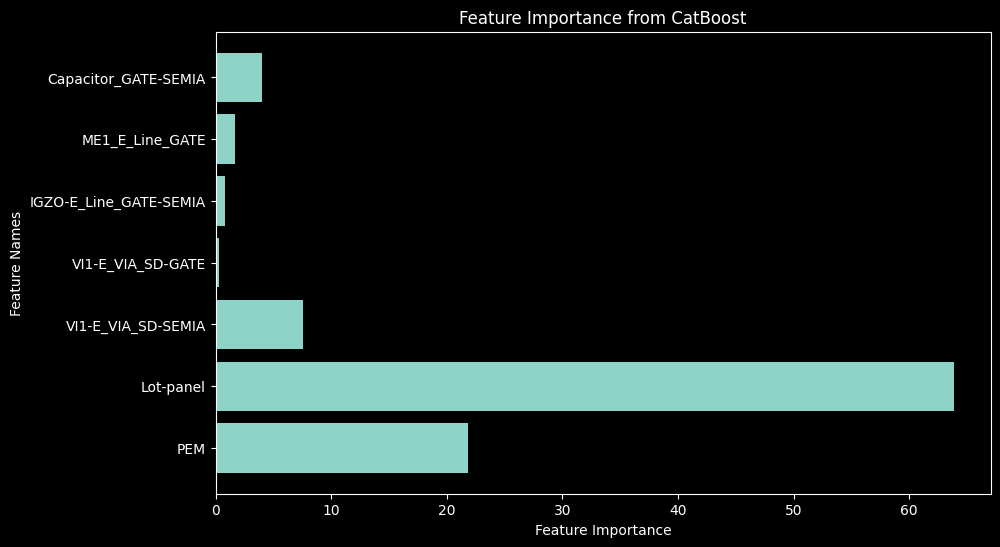

In [459]:
# Оценка важности признаков
feature_importance = model.get_feature_importance(type="FeatureImportance")

# Получение названий признаков
feature_names = X

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance from CatBoost')
plt.show()

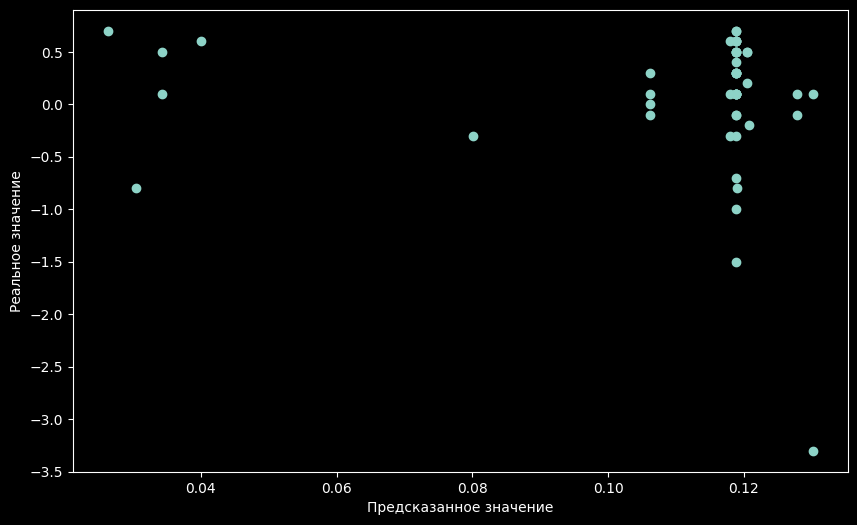

In [492]:
# Строю график соотношения Реального значения Von к Предсказанному значению
plt.figure(figsize=(10, 6))
plt.scatter(res_list, real_value['Von'])

plt.xlabel('Предсказанное значение')
plt.ylabel('Реальное значение')
plt.title('')
plt.show()